# Chinese OCR

This script is a comprehensive Chinese OCR pipeline designed for recognizing handwritten Chinese characters. It proceeds in multiple steps, starting with importing essential libraries for data handling, visualization, image processing, and deep learning. First, it loads and organizes a dataset of handwritten Chinese characters, setting up a structured DataFrame that links each image with metadata like its character label and path. Then, it prepares training, validation, and test directories, transferring files accordingly.

For data preparation, the script defines image preprocessing steps, including resizing, grayscale conversion, normalization, and random augmentation, which are then applied to images in a DataLoader for training and evaluation. The model architecture, CRNN (Convolutional Recurrent Neural Network), combines a CNN for feature extraction with an LSTM for sequence prediction, leveraging the sequential nature of handwriting for effective recognition.

The training function iterates over the data, optimizing the model with backpropagation and saving the best-performing model based on validation accuracy. After training, the script includes functions for visualizing accuracy and loss trends and testing the model on sample images to verify predictions. Lastly, it demonstrates reusability by applying the trained model to a new set of images from the “Guilhem” dataset, displaying the results in a visually organized format.

Dataset used: [Handwritten Chinese Character (Hanzi) Datasets](https://www.kaggle.com/datasets/pascalbliem/handwritten-chinese-character-hanzi-datasets), originated from the [CASIA Online and Offline Chinese Handwriting Databases](http://www.nlpr.ia.ac.cn/databases/handwriting/Home.html).

Script adapted from: [Chinese Characters (HSK 1 level) Recognition](https://www.kaggle.com/code/artemborzenko/chinese-characters-hsk-1-level-recognition/notebook)

## Table of Contents
1. [Import Libraries](#import-libraries)
2. [Creation of the Dataset](#creation-of-the-dataset)
3. [Image and Dataset Preparations](#image-and-dataset-preparations)
4. [Model Building & Training](#model-building--training)
    - 4.1. [CRNN Model](#crnn-model)
    - 4.2. [Training](#training)
        - 4.2.1 [Train Summary](#train-summary)
5. [Model Evaluation and Conclusion](#model-evaluation-and-conclusion)
6. [Reuse of the Model on the Guilhem Dataset](#reuse-of-the-model-on-the-guilhem-dataset)

<a id="import-libraries"></a>
## 1. Import Libraries

In [1]:
import os
import sys
import shutil
import random
import time

from tqdm.notebook import tqdm

import cv2
import json
from PIL import Image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import plotly.figure_factory as ff
from sklearn.metrics import classification_report

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.nn.modules.container import Sequential
from torch.nn.utils.rnn import pad_sequence
from torch.autograd import Variable

import torchvision
import torchvision.models as models
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader

<a id="creation-of-the-dataset"></a>
## 2. Creation of the Dataset


In [ ]:
# Creation of the DataFrame columns
columns = ["Character_ID", "Character", "Paths", "Directory", "File_Name"]
IDS = []
characters = []
paths = []
files_names = []
directories_names = []

# Initialisation of the ID
id = -1

# Initialisation of the valid characters
paths_dirs = ["CASIA-HWDB_Train", "CASIA-HWDB_Test"]
ROOT_PATH = "data/handwritten-chinese-character-hanzi-datasets/"
characters_file_path = "data/120_classes.txt"

with open(characters_file_path, "r", encoding="utf-8") as file:
    valid_characters = [char.strip() for char in file if char.strip()]

# print(len(valid_characters))

# Iterating over the directories
for path_dir in paths_dirs:
    # Initialisation of the PATH
    PATH = f"{ROOT_PATH}{path_dir}/{path_dir[11:]}"
    
    for directory in tqdm(os.listdir(PATH)):
        if directory != ".DS_Store" and directory in valid_characters:
            id += 1
            # Iterating over the files
            for file in os.listdir(f"{PATH}/{directory}"):
                IDS.append(id)
                characters.append(directory)
                paths.append(f"{PATH}/{directory}/{file}")
                files_names.append(file)
                directories_names.append(path_dir[11:])

# Creation of the DataFrame
data = pd.DataFrame({
    columns[0]: IDS,
    columns[1]: characters,
    columns[2]: paths,
    columns[3]: directories_names,
    columns[4]: files_names
})

data.to_csv("data/data_120.csv", index=False)

In [ ]:
# Load the DataFrame
data = pd.read_csv("data/data_120.csv")

# Create the new directories
NEW_ROOT_PATH = "./data/NewData120/"
os.makedirs(os.path.join(NEW_ROOT_PATH, "Train"), exist_ok=True)
os.makedirs(os.path.join(NEW_ROOT_PATH, "Test"), exist_ok=True)

# Copy the files to the new directories
for _, row in tqdm(data.iterrows(), total=len(data)):
    character = row["Character"]
    directory_type = row["Directory"]
    
    # Create the new subdirectory
    new_subdir_path = os.path.join(NEW_ROOT_PATH, directory_type, character)
    os.makedirs(new_subdir_path, exist_ok=True)
    
    # Define the source and destination paths
    src_path = row["Paths"]
    dest_path = os.path.join(new_subdir_path, row["File_Name"])
    
    # Copy the file
    shutil.copy(src_path, dest_path)

print("Files copied successfully!")

Display some information about the dataset (number of images and classes).

In [ ]:
data = pd.read_csv("data/data_120.csv")

In [ ]:
print(f"There are {data.shape[0]} images in whole dataset.")
print(f"{len(data[data['Directory'] == 'Train'])} images in Train directory and {len(data[data['Directory'] == 'Test'])} in Test part.")
print(f"{round(np.array(data['Character_ID']).max() / 2)} characters (classes).")

There are 88994 images in whole dataset.
71856 images in Train directory and 17138 in Test part.
120 characters (classes).


In [ ]:
def count_of_each_character(directory: str):
    """
    Count of each character in the dataset.

    Parameters:
        directory (str): The directory name.
    """

    characters_file_path = "data/120_classes.txt"

    with open(characters_file_path, "r", encoding="utf-8") as file:
        valid_characters = [char.strip() for char in file if char.strip()]
        
    count_numbers = []
    classes = []

    j = 0
    PATH = f"./data/NewData120/{directory}"
    for character in os.listdir(PATH):
        if character == ".DS_Store" or character not in valid_characters:
            continue
        
        classes.append(character)
        for image in os.listdir(os.path.join(PATH, character)):
            j += 1

        count_numbers.append(j)
        j = 0

    # Plot the distribution of the count of images
    fig = go.Figure(data = [go.Bar(x = classes, y = count_numbers, marker_color = "royalblue")])

    fig.update_layout(title = f"Distribution of count of Images in {directory} dataset", xaxis_title = "Characters", yaxis_title = "Count", legend_title = "Legend")
    fig.update_layout(barmode = "group", xaxis={'categoryorder' : 'total descending'}, xaxis_tickangle = 0)

    fig.show()

In [ ]:
count_of_each_character("Train")

In [ ]:
count_of_each_character("Test")

Path: ./data/NewData120/Train/虽/68.png
Image loaded with success.
Character: 虽


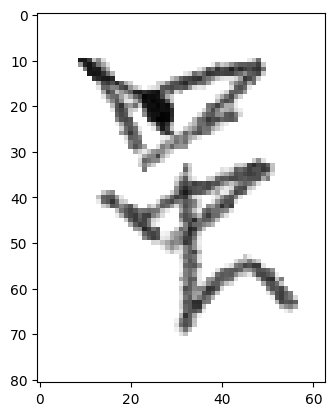

In [ ]:
def show_example_image(dataset: pd.DataFrame, part: str):
    """
    Show an example image from the dataset.

    Parameters:
        dataset (pd.DataFrame): The dataset.
        part (str): The part of the dataset (Train or Test
    """
    n = random.randint(50, 80)
    char = random.choice(dataset["Character"])
    
    PATH2image = f"./data/NewData120/{part}/{char}/{n}.png"

    print(f"Path: {PATH2image}")

    # Load the image using PIL and convert it to a numpy array compatible with OpenCV
    try:
        example_image_pil = Image.open(PATH2image)
        example_image = np.array(example_image_pil)
        print("Image loaded with success.")
    except Exception as e:
        print(f"Error: Unable to load the image {PATH2image}. Details: {e}")
        return

    # Verify if the image is in grayscale and adjust if necessary
    if example_image.ndim == 2:
        # Alredy in grayscale
        print(f"Image in grayscale: {example_image.shape}")
    elif example_image.shape[2] == 3:
        # Convert to grayscale if it is in RGB
        example_image = cv2.cvtColor(example_image, cv2.COLOR_RGB2GRAY)
        print(f"Image converted to grayscale: {example_image.shape}")

    print(f"Character: {char}")
    plt.axis()
    plt.imshow(example_image, cmap="gray")
    plt.show()

show_example_image(data, "Train")

<a id="image-and-dataset-preparations"></a>
## 3. Image and dataset preparations

In [ ]:
def move_validation_files(folder: str):
    """
    Move the validation files to the validation folder.

    Parameters:
        folder (str): The folder name
    """
    # Create the parent directories if necessary
    validation_images_path = "./data/NewData120/Validation_Images"
    if not os.path.exists(validation_images_path):
        os.makedirs(validation_images_path)
    
    # Create the folder for the specific character
    folder_path = os.path.join(validation_images_path, str(folder))
    if not os.path.exists(folder_path):
        os.mkdir(folder_path)

    destination_path = os.path.join(validation_images_path, str(folder))
    folder_path_train = os.path.join("./data/NewData120/Train", str(folder))

    try:
        files = os.listdir(folder_path_train)
        for i in range(min(75, len(files))):
            file = files[i]  
            shutil.move(os.path.join(folder_path_train, file), destination_path)
    except FileNotFoundError as e:
        print(f"Error : {e}")
    except Exception as e:
        print(f"Another error : {e}")

folders = data["Character"].unique()

for folder in folders:
    move_validation_files(folder)


Another error : Destination path './data/NewData120/Validation_Images\一\1.png' already exists
Another error : Destination path './data/NewData120/Validation_Images\上\1.png' already exists
Another error : Destination path './data/NewData120/Validation_Images\下\1.png' already exists
Another error : Destination path './data/NewData120/Validation_Images\不\1.png' already exists
Another error : Destination path './data/NewData120/Validation_Images\与\1.png' already exists
Another error : Destination path './data/NewData120/Validation_Images\个\1.png' already exists
Another error : Destination path './data/NewData120/Validation_Images\中\1.png' already exists
Another error : Destination path './data/NewData120/Validation_Images\为\1.png' already exists
Another error : Destination path './data/NewData120/Validation_Images\主\1.png' already exists
Another error : Destination path './data/NewData120/Validation_Images\之\1.png' already exists
Another error : Destination path './data/NewData120/Validati

In [ ]:
image_transformer = transforms.Compose([
    transforms.Resize((96, 96)),  # Resize images to 96x96 pixels
    transforms.Grayscale(num_output_channels=1),  # Convert to grayscale
    transforms.ToTensor(),  # Convert to pytorch tensor
    transforms.RandomApply([
        transforms.RandomRotation(25),  # Random rotation of the image
        transforms.RandomAutocontrast()  # Ajust the contrast of the image
    ], p=0.6),  # Apply the transformations with a probability of 0.6
    transforms.Normalize([0.5], [0.5])  # Normalise the image
])

# Load the datasets
train_data = datasets.ImageFolder("./data/NewData120/Train", transform = image_transformer)
test_data = datasets.ImageFolder("./data/NewData120/Test", transform = image_transformer)
val_data = datasets.ImageFolder("./data/NewData120/Validation_Images", transform = image_transformer)

In [ ]:
# Load the dataloaders
train_loader = torch.utils.data.DataLoader(train_data, batch_size = 16, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_data, batch_size = 16, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_data, batch_size = 16, shuffle=False)

In [ ]:
for images, labels in train_loader:
    print(images.shape)  # Should be (batch_size, 1, 96, 96) if transformed correctly
    break

torch.Size([16, 1, 96, 96])


In [ ]:
# Check the loaders
print(f"Checking Train loader: {type(train_loader)}")
print(f"Checking Validation loader: {type(val_loader)}")
print(f"Checking Test loader: {type(test_loader)}")

Checking Train loader: <class 'torch.utils.data.dataloader.DataLoader'>
Checking Validation loader: <class 'torch.utils.data.dataloader.DataLoader'>
Checking Test loader: <class 'torch.utils.data.dataloader.DataLoader'>


In [ ]:
# Creation of the dictionary for the interpretation
nums = range(0, 7330)
labels = sorted([dir for dir in os.listdir("./data/NewData120/Train") if dir != ".DS_Store"])

interpritation_dict = dict(zip(nums, labels))

# Save the dictionary
torch.save(interpritation_dict, "./model/interpritation_dict_120classes.pth")

interpritation_dict

{0: '一',
 1: '上',
 2: '下',
 3: '不',
 4: '与',
 5: '个',
 6: '中',
 7: '为',
 8: '主',
 9: '之',
 10: '也',
 11: '了',
 12: '事',
 13: '于',
 14: '人',
 15: '今',
 16: '他',
 17: '以',
 18: '们',
 19: '会',
 20: '但',
 21: '你',
 22: '做',
 23: '出',
 24: '分',
 25: '划',
 26: '前',
 27: '力',
 28: '功',
 29: '动',
 30: '原',
 31: '发',
 32: '只',
 33: '可',
 34: '各',
 35: '同',
 36: '后',
 37: '向',
 38: '听',
 39: '和',
 40: '四',
 41: '因',
 42: '国',
 43: '在',
 44: '地',
 45: '外',
 46: '大',
 47: '天',
 48: '女',
 49: '好',
 50: '如',
 51: '子',
 52: '学',
 53: '安',
 54: '定',
 55: '对',
 56: '小',
 57: '就',
 58: '工',
 59: '常',
 60: '年',
 61: '应',
 62: '当',
 63: '得',
 64: '心',
 65: '必',
 66: '想',
 67: '成',
 68: '我',
 69: '所',
 70: '手',
 71: '才',
 72: '排',
 73: '放',
 74: '旅',
 75: '日',
 76: '时',
 77: '明',
 78: '是',
 79: '最',
 80: '有',
 81: '本',
 82: '来',
 83: '每',
 84: '水',
 85: '洒',
 86: '游',
 87: '点',
 88: '热',
 89: '然',
 90: '物',
 91: '现',
 92: '生',
 93: '的',
 94: '看',
 95: '知',
 96: '种',
 97: '第',
 98: '而',
 99: '能',
 100: '自',

torch.Size([16, 1, 96, 96])
0) 于
1) 功
2) 四
3) 成
4) 因
5) 们
6) 会
7) 做
8) 成
9) 地


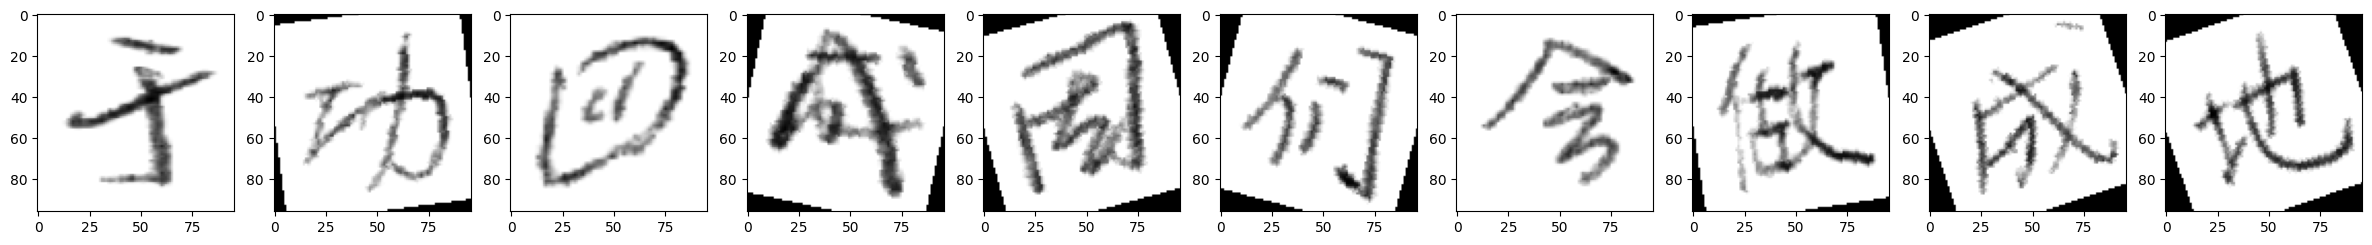

In [ ]:
# Visualize the images
dataiter = iter(train_loader) # Create an iterator
images, labels = next(dataiter) # Get the next batch of images
print(images.shape)

def loaders_viz(imgs, labels):
  """
  Loaders visualization.

  Parameters:
      imgs (Tensor): The images.
      labels (Tensor): The labels.
  """
  # Create a figure and a grid of subplots
  f, axes = plt.subplots(1, 10, figsize=(30,5))
  for i, axis in enumerate(axes):
      axes[i].imshow(np.squeeze(np.transpose(imgs[i][0].numpy(), (0, 1))), cmap = "gray") # Display the image
      print(f"{i}) {interpritation_dict[int(labels[i].numpy())]}") # Print the label

  plt.show()

loaders_viz(images, labels)

<a id="model-building--training"></a>
## 4. Model building & training

We will use CRNN (Convolutional Recurrent Neural Network) for this task. The model consists of a CNN for feature extraction and a RNN for sequence prediction. Why CRNN? Because it is a powerful model for text recognition in images.

<a id="crnn-model"></a>
### 4.1. CRNN Model

In [2]:
def CNN_backbone():
    """
    CNN backbone, the feature extractor.

    Returns:
        nn.Sequential: The CNN backbone.
    """
    relu = nn.ReLU()  # ReLU activation function to introduce non-linearity
    
    # Define convolutional layers with increasing filter sizes
    conv1 = nn.Conv2d(in_channels=1, out_channels=64, kernel_size=(7, 7))  # 1st conv layer
    conv2 = nn.Conv2d(in_channels=64, out_channels=96, kernel_size=(7, 7)) # 2nd conv layer
    conv3 = nn.Conv2d(in_channels=96, out_channels=128, kernel_size=(5, 5)) # 3rd conv layer
    conv4 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=(5, 5)) # 4th conv layer
    conv5 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=(3, 3)) # 5th conv layer
    conv6 = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=(3, 3)) # 6th conv layer
    
    pool = nn.MaxPool2d(kernel_size=(2, 2))  # Max pooling to reduce spatial dimensions
    
    conv7 = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=(3, 3)) # 7th conv layer
    bn1 = nn.BatchNorm2d(256)  # Batch normalization for regularization and stability
    conv8 = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=(3, 3)) # 8th conv layer
    
    # Arrange all layers in a list for sequential execution in the network
    blocks = [conv1, relu, conv2, relu, conv3, relu, conv4, relu, 
              conv5, relu, conv6, pool, relu, conv7, bn1, relu, conv8, relu]
              
    return nn.Sequential(*blocks)  # Return CNN backbone as a Sequential model


class CRNN(nn.Module):
    def __init__(self, number_class_symbols):
        super().__init__()
        self.feature_extractor = CNN_backbone()  # Initialize CNN backbone as the feature extractor
        
        # Average pooling to downsample the extracted features
        self.avg_pool1 = nn.AdaptiveAvgPool2d((100, 100))
        
        # Bi-directional LSTM to capture temporal dependencies in features
        self.bilstm = nn.LSTM(input_size=100, hidden_size=100, num_layers=1, 
                              batch_first=True, bidirectional=True)
                              
        # Second average pooling to further reduce feature dimensions
        self.avg_pool2 = nn.AdaptiveAvgPool2d((64, 64))
        
        self.flatten = nn.Flatten()  # Flatten layer to prepare features for fully connected layers
        
        # Fully connected layers for classification
        self.fc1 = nn.Linear(64 * 64, 32)  # First fully connected layer
        self.gelu = nn.GELU()  # GELU activation for non-linearity
        self.dropout = nn.Dropout(0.1)  # Dropout for regularization
        self.fc2 = nn.Linear(32, number_class_symbols)  # Final layer to output class probabilities

    def forward(self, x):
        # Pass input through the CNN feature extractor
        x = self.feature_extractor(x)
        
        # Reshape tensor for LSTM input
        b, c, h, w = x.size()  # Get batch, channel, height, and width
        x = x.view(b, c * h, w)  # Reshape to prepare for average pooling
        
        # Apply adaptive average pooling
        x = self.avg_pool1(x)
        
        # Prepare input for LSTM
        x = x.transpose(1, 2)  # Transpose to match LSTM input shape
        x, _ = self.bilstm(x)  # Pass through the Bi-LSTM layer
        
        # Apply second adaptive average pooling
        x = self.avg_pool2(x)
        
        # Flatten for the fully connected layers
        x = self.flatten(x)
        
        # Pass through fully connected layers with GELU and dropout
        x = torch.sigmoid(self.fc1(x))
        x = self.gelu(x)
        x = self.dropout(x)
        
        x = self.fc2(x)  # Final layer
        
        return F.log_softmax(x, dim=1)  # Apply log softmax for class probability output

In [ ]:
!nvidia-smi

Sun Nov  3 09:49:33 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 566.03                 Driver Version: 566.03         CUDA Version: 12.7     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                  Driver-Model | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 2060 ...  WDDM  |   00000000:26:00.0  On |                  N/A |
| 55%   44C    P0             26W /  175W |     453MiB /   8192MiB |      9%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [ ]:
# Check if the device is available
if torch.backends.mps.is_available():
    device = torch.device('mps')
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

print(f"Device: {device}")

# Initialize the model
data = pd.read_csv("data/data_120.csv")
model = CRNN(number_class_symbols = len(data["Character"].unique()))
model.to(device)
model

Device: cuda


CRNN(
  (feature_extractor): Sequential(
    (0): Conv2d(1, 64, kernel_size=(7, 7), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(64, 96, kernel_size=(7, 7), stride=(1, 1))
    (3): ReLU()
    (4): Conv2d(96, 128, kernel_size=(5, 5), stride=(1, 1))
    (5): ReLU()
    (6): Conv2d(128, 128, kernel_size=(5, 5), stride=(1, 1))
    (7): ReLU()
    (8): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1))
    (9): ReLU()
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1))
    (11): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    (12): ReLU()
    (13): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1))
    (14): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (15): ReLU()
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1))
    (17): ReLU()
  )
  (avg_pool1): AdaptiveAvgPool2d(output_size=(100, 100))
  (bilstm): LSTM(100, 100, batch_first=True, bidirectional=True)
  (avg_pool2): AdaptiveAvgPool2

<a id="training"></a>
### 4.2. Training

In [ ]:
# Initialize the optimizer with AdamW and set learning rate and weight decay
optimizer = torch.optim.AdamW(model.parameters(), lr=0.00125, weight_decay=0.01)

# Set the loss function as CrossEntropy, suitable for multi-class classification
loss_fn = torch.nn.CrossEntropyLoss()

def train(model: nn.Module, optimizer: torch.optim, loss_fn: torch.nn, train_dl: DataLoader, val_dl: DataLoader, history_path: str, save_path:str, epochs: int = 100, device: str = 'cpu') -> dict:
    """
    Train the model.

    Parameters:
        model (nn.Module): The model to train.
        optimizer (torch.optim): The optimizer to use for training.
        loss_fn (torch.nn): The loss function to use.
        train_dl (DataLoader): The training DataLoader.
        val_dl (DataLoader): The validation DataLoader.
        epochs (int): The number of epochs to train for.
        device (str): The device to train on.
        save_path (str): The path to save the best model.
    
    Returns:
        dict: The training history.
    """
    
    # Print training settings summary
    print('train() called: Model = %s, Optimizer = %s(lr=%f), Epochs = %d, Device = %s\n' % \
          (type(model).__name__, type(optimizer).__name__,
           optimizer.param_groups[0]['lr'], epochs, device))

    # Initialize history dictionary to store training and validation metrics
    history = {'loss': [], 'val_loss': [], 'acc': [], 'val_acc': []}
    best_train_acc = 0  # Track best training accuracy
    best_val_acc = 0    # Track best validation accuracy
    start_time_sec = time.time()  # Track total training time

    # Training loop over the specified number of epochs
    for epoch in tqdm(range(1, epochs + 1), desc='Epochs', unit='epoch'):
        model.train()  # Set the model to training mode
        train_loss = 0.0
        num_train_correct = 0
        num_train_examples = 0
        epoch_start_time_sec = time.time()  # Track epoch time

        # Iterate over batches in training data
        for batch in tqdm(train_dl, desc='Training Batches', unit='batch', leave=False):
            optimizer.zero_grad()  # Reset gradients before backpropagation
            x = batch[0].to(device)  # Move input data to the specified device
            y = batch[1].to(device)  # Move target labels to the specified device
            yhat = model(x)  # Forward pass: get model predictions
            loss = loss_fn(yhat, y)  # Calculate loss between predictions and targets

            loss.backward()  # Backward pass to compute gradients
            optimizer.step()  # Update model weights based on gradients

            # Accumulate training loss and count correct predictions
            train_loss += loss.data.item() * x.size(0)  # Multiply by batch size to aggregate correctly
            num_train_correct += (torch.max(yhat, 1)[1] == y).sum().item()  # Count correct predictions
            num_train_examples += x.shape[0]  # Track number of training examples

        # Calculate epoch training accuracy and average loss
        train_acc = num_train_correct / num_train_examples
        train_loss = train_loss / len(train_dl.dataset)

        model.eval()  # Set model to evaluation mode for validation
        val_loss = 0.0
        num_val_correct = 0
        num_val_examples = 0

        # Iterate over batches in validation data
        for batch in val_dl:
            x = batch[0].to(device)
            y = batch[1].to(device)
            yhat = model(x)
            loss = loss_fn(yhat, y)

            # Accumulate validation loss and count correct predictions
            val_loss += loss.data.item() * x.size(0)
            num_val_correct += (torch.max(yhat, 1)[1] == y).sum().item()
            num_val_examples += y.shape[0]

        # Calculate epoch validation accuracy and average loss
        val_acc = num_val_correct / num_val_examples
        val_loss = val_loss / len(val_dl.dataset)
        
        epoch_end_time_sec = time.time()
        epoch_time_sec = epoch_end_time_sec - epoch_start_time_sec  # Calculate epoch duration

        # Print epoch summary of loss and accuracy
        print(f"Epoch {epoch}, time: {round(epoch_time_sec)} seconds. Train loss: {round(train_loss, 3)}, train accuracy: {round(train_acc, 3)}. Val loss: {round(val_loss, 3)}, val accuracy: {round(val_acc, 3)}")
        
        # Update best accuracies if the current ones are higher
        if train_acc > best_train_acc and val_acc > best_val_acc:
            best_train_acc = train_acc
            best_val_acc = val_acc
            best_epoch = epoch  # Track the epoch of the best accuracy
            torch.save(model.state_dict(), save_path)  # Save the best model's state dict

        # Record metrics in history for analysis and plotting
        history['loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        history['acc'].append(train_acc)
        history['val_acc'].append(val_acc)


    end_time_sec = time.time()
    total_time_sec = end_time_sec - start_time_sec  # Calculate total training time
    print("\n")
    print(f"Training Time: {round(total_time_sec)} seconds")
    print(f"The best epoch: {best_epoch}, Train Accuracy: {round(best_train_acc, 3)}, Validation Accuracy: {round(best_val_acc, 3)}")

    # Save history to a JSON file
    with open(history_path, 'w') as f:
        json.dump(history, f)

    return history  # Return training history for further analysis

In [ ]:
history = train(model = model, optimizer = optimizer, loss_fn = loss_fn, epochs = 20, history_path="model/history_120.json", save_path = "model/best_model_120classes.pth",
                train_dl = train_loader, val_dl = val_loader, device = device)

train() called: Model = CRNN, Optimizer = AdamW(lr=0.001250), Epochs = 20, Device = cuda



Epochs:   0%|          | 0/20 [00:00<?, ?epoch/s]

Training Batches:   0%|          | 0/4491 [00:00<?, ?batch/s]

Epoch 1, time: 1049 seconds. Train loss: 3.47, train accuracy: 0.205. Val loss: 2.813, val accuracy: 0.314


Training Batches:   0%|          | 0/4491 [00:00<?, ?batch/s]

Epoch 2, time: 1059 seconds. Train loss: 2.151, train accuracy: 0.469. Val loss: 1.964, val accuracy: 0.5


Training Batches:   0%|          | 0/4491 [00:00<?, ?batch/s]

Epoch 3, time: 1040 seconds. Train loss: 1.511, train accuracy: 0.622. Val loss: 1.134, val accuracy: 0.728


Training Batches:   0%|          | 0/4491 [00:00<?, ?batch/s]

Epoch 4, time: 1215 seconds. Train loss: 1.175, train accuracy: 0.698. Val loss: 0.926, val accuracy: 0.767


Training Batches:   0%|          | 0/4491 [00:00<?, ?batch/s]

Epoch 5, time: 1250 seconds. Train loss: 0.97, train accuracy: 0.748. Val loss: 0.763, val accuracy: 0.805


Training Batches:   0%|          | 0/4491 [00:00<?, ?batch/s]

Epoch 6, time: 1182 seconds. Train loss: 0.839, train accuracy: 0.779. Val loss: 0.675, val accuracy: 0.825


Training Batches:   0%|          | 0/4491 [00:00<?, ?batch/s]

Epoch 7, time: 1257 seconds. Train loss: 0.731, train accuracy: 0.808. Val loss: 0.572, val accuracy: 0.854


Training Batches:   0%|          | 0/4491 [00:00<?, ?batch/s]

Epoch 8, time: 1296 seconds. Train loss: 0.667, train accuracy: 0.823. Val loss: 0.472, val accuracy: 0.879


Training Batches:   0%|          | 0/4491 [00:00<?, ?batch/s]

Epoch 9, time: 1217 seconds. Train loss: 0.609, train accuracy: 0.839. Val loss: 0.419, val accuracy: 0.891


Training Batches:   0%|          | 0/4491 [00:00<?, ?batch/s]

Epoch 10, time: 1168 seconds. Train loss: 0.56, train accuracy: 0.85. Val loss: 0.384, val accuracy: 0.901


Training Batches:   0%|          | 0/4491 [00:00<?, ?batch/s]

Epoch 11, time: 1178 seconds. Train loss: 0.521, train accuracy: 0.861. Val loss: 0.359, val accuracy: 0.907


Training Batches:   0%|          | 0/4491 [00:00<?, ?batch/s]

Epoch 12, time: 1249 seconds. Train loss: 0.491, train accuracy: 0.869. Val loss: 0.34, val accuracy: 0.911


Training Batches:   0%|          | 0/4491 [00:00<?, ?batch/s]

Epoch 13, time: 1263 seconds. Train loss: 0.467, train accuracy: 0.875. Val loss: 0.313, val accuracy: 0.917


Training Batches:   0%|          | 0/4491 [00:00<?, ?batch/s]

Epoch 14, time: 1420 seconds. Train loss: 0.439, train accuracy: 0.883. Val loss: 0.284, val accuracy: 0.926


Training Batches:   0%|          | 0/4491 [00:00<?, ?batch/s]

Epoch 15, time: 1081 seconds. Train loss: 0.422, train accuracy: 0.888. Val loss: 0.289, val accuracy: 0.924


Training Batches:   0%|          | 0/4491 [00:00<?, ?batch/s]

Epoch 16, time: 1163 seconds. Train loss: 0.406, train accuracy: 0.892. Val loss: 0.298, val accuracy: 0.922


Training Batches:   0%|          | 0/4491 [00:00<?, ?batch/s]

Epoch 17, time: 1166 seconds. Train loss: 0.381, train accuracy: 0.897. Val loss: 0.244, val accuracy: 0.935


Training Batches:   0%|          | 0/4491 [00:00<?, ?batch/s]

Epoch 18, time: 1200 seconds. Train loss: 0.366, train accuracy: 0.902. Val loss: 0.248, val accuracy: 0.933


Training Batches:   0%|          | 0/4491 [00:00<?, ?batch/s]

Epoch 19, time: 1081 seconds. Train loss: 0.359, train accuracy: 0.903. Val loss: 0.221, val accuracy: 0.942


Training Batches:   0%|          | 0/4491 [00:00<?, ?batch/s]

Epoch 20, time: 1232 seconds. Train loss: 0.342, train accuracy: 0.909. Val loss: 0.227, val accuracy: 0.94


Training Time: 23765 seconds
The best epoch: 19, Train Accuracy: 0.903, Validation Accuracy: 0.942


<a id="train-summary"></a>
#### 4.2.1. Train Summary

In [ ]:
from plotly.subplots import make_subplots

def train_summary(model_name: str, history: dict, epochs: list):
    """
    Plot the training and validation accuracy and loss over epochs.

    Parameters:
        model_name (str): The name of the model being trained.
        history (dict): Dictionary containing 'acc', 'val_acc', 'loss', and 'val_loss' lists.
        epochs (list): List of epoch numbers.
    """
    
    # Create a figure with 1 row and 2 columns for subplots: one for accuracy and one for loss
    fig = make_subplots(rows=1, cols=2, subplot_titles=("Train/Val accuracy", "Train/Val loss"))
    
    # Plot the training accuracy over epochs on the first subplot
    fig.add_trace(go.Scatter(x=epochs, y=history["acc"],
                             mode="lines+markers",  # Plot lines with markers at each data point
                             name="Train Accuracy"),
                             row=1, col=1)  # Place in the first row, first column
    
    # Plot the validation accuracy over epochs on the first subplot
    fig.add_trace(go.Scatter(x=epochs, y=history["val_acc"],
                             mode="lines+markers",
                             name="Validation Accuracy"),
                             row=1, col=1)  # Place in the first row, first column

    # Plot the training loss over epochs on the second subplot
    fig.add_trace(go.Scatter(x=epochs, y=history["loss"],
                             mode="lines+markers",
                             name="Train Loss"),
                             row=1, col=2)  # Place in the first row, second column
    
    # Plot the validation loss over epochs on the second subplot
    fig.add_trace(go.Scatter(x=epochs, y=history["val_loss"],
                             mode="lines+markers",
                             name="Validation Loss"),
                             row=1, col=2)  # Place in the first row, second column    
    
    # Update the overall layout of the figure
    fig.update_layout(height=700, width=1200, title_text="Model training Summary", legend_title="Legend")
    
    # Set x-axis label for both subplots
    fig.update_xaxes(title_text="Epochs")
    
    # Set y-axis label specifically for accuracy in the first subplot
    fig.update_yaxes(title_text="Accuracy", row=1, col=1)
    
    # Set y-axis label specifically for loss in the second subplot
    fig.update_yaxes(title_text="Loss", row=1, col=2)

    fig.write_image("model/training_summary_120classes.png")

    # Display the figure
    fig.show()

In [ ]:
train_summary("CRNN", history, list(range(1, 15 + 1)))

<a id="model-evaluation-and-conclusion"></a>
## 5. Model Evaluation and Conclusion

In [ ]:
def evaluate_best_model(model: nn.Module, test_dl: DataLoader, device: str = 'cpu'):
    """
    Evaluate the best model on the test set and calculate precision, recall, and F1 score (micro, macro, and weighted).
    
    Parameters:
        model (nn.Module): The trained model to be evaluated.
        test_dl (DataLoader): The DataLoader containing validation data.
        device (str): The device (CPU or GPU) on which evaluation is performed.

    Returns:
        dict: Dictionary containing precision, recall, and F1 score for micro, macro, and weighted averages.
    """
    model.eval()  # Set the model to evaluation mode
    all_preds = []
    all_labels = []

    # Disable gradient computation for efficiency during evaluation
    with torch.no_grad():
        for batch in tqdm(test_dl, desc='Evaluating Best Model'):
            x = batch[0].to(device)  # Move inputs to the selected device
            y = batch[1].to(device)  # Move true labels to the selected device
            yhat = model(x)  # Get model predictions

            # Store predictions and true labels
            all_preds.extend(torch.argmax(yhat, dim=1).cpu().numpy())
            all_labels.extend(y.cpu().numpy())

    # Calculate precision, recall, and F1-score using sklearn
    report = classification_report(all_labels, all_preds, output_dict=True)
    # print(report)
    
    # Extract relevant metrics from the report
    metrics = {
        'accuracy': report['accuracy'],  # Overall accuracy as micro-average
        'precision_macro': report['macro avg']['precision'],  # Macro-averaged precision
        'recall_macro': report['macro avg']['recall'],        # Macro-averaged recall
        'f1_macro': report['macro avg']['f1-score'],          # Macro-averaged F1 score
        'precision_weighted': report['weighted avg']['precision'],  # Weighted precision
        'recall_weighted': report['weighted avg']['recall'],        # Weighted recall
        'f1_weighted': report['weighted avg']['f1-score']           # Weighted F1 score
    }
    
    # Print and save the detailed report
    print("Detailed Classification Report for Each Label:")
    for label, metrics in report.items():
        if label.isdigit():  # Check if the key is a class label
            label_name = interpritation_dict[int(label)]
            print(f"Label '{label_name}' (Class {label}):")
            print(f"  Precision: {metrics['precision']:.4f}")
            print(f"  Recall:    {metrics['recall']:.4f}")
            print(f"  F1 Score:  {metrics['f1-score']:.4f}")
            print(f"  Support:   {metrics['support']}\n")

    # Extract overall metrics from the report
    metrics = {
        'accuracy': report['accuracy'],
        'precision_macro': report['macro avg']['precision'],
        'recall_macro': report['macro avg']['recall'],
        'f1_macro': report['macro avg']['f1-score'],
        'precision_weighted': report['weighted avg']['precision'],
        'recall_weighted': report['weighted avg']['recall'],
        'f1_weighted': report['weighted avg']['f1-score']
    }

    # Print summary metrics
    print("\nSummary Evaluation Metrics for the Best Model:")
    for metric, value in metrics.items():
        print(f"{metric}: {value:.4f}")

    # Save detailed metrics to a text file
    with open("model/best_model_metrics_120.txt", 'w') as f:
        # Write summary metrics
        f.write("Summary Evaluation Metrics for the Best Model:\n")
        for metric, value in metrics.items():
            f.write(f"{metric}: {value:.4f}\n")
        
        f.write("\nDetailed Classification Report for Each Label:\n")
        for label, metrics in report.items():
            if label.isdigit():
                label_name = interpritation_dict[int(label)]
                f.write(f"Label '{label_name}' (Class {label}):\n")
                f.write(f"  Precision: {metrics['precision']:.4f}\n")
                f.write(f"  Recall:    {metrics['recall']:.4f}\n")
                f.write(f"  F1 Score:  {metrics['f1-score']:.4f}\n")
                f.write(f"  Support:   {metrics['support']}\n\n")
        
    return metrics

# Load and evaluate the best model
best_model_path = "./model/best_model_120classes.pth"
model.load_state_dict(torch.load(best_model_path, map_location=torch.device('cpu')))  # Load the best model's weights
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')  # Check if a GPU is available
model.to(device)
best_model_metrics = evaluate_best_model(model, test_loader, device=device)  # Evaluate model on test data

C:\Users\Perrine\AppData\Local\Temp\ipykernel_19716\3242602536.py:91: FutureWarning:

You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.



Evaluating Best Model:   0%|          | 0/1072 [00:00<?, ?it/s]

Detailed Classification Report for Each Label:
Label '一' (Class 0):
  Precision: 0.9728
  Recall:    0.9931
  F1 Score:  0.9828
  Support:   144.0

Label '上' (Class 1):
  Precision: 0.8438
  Recall:    0.9375
  F1 Score:  0.8882
  Support:   144.0

Label '下' (Class 2):
  Precision: 0.8944
  Recall:    0.8819
  F1 Score:  0.8881
  Support:   144.0

Label '不' (Class 3):
  Precision: 0.7778
  Recall:    0.8873
  F1 Score:  0.8289
  Support:   142.0

Label '与' (Class 4):
  Precision: 0.9203
  Recall:    0.8819
  F1 Score:  0.9007
  Support:   144.0

Label '个' (Class 5):
  Precision: 0.9615
  Recall:    0.8803
  F1 Score:  0.9191
  Support:   142.0

Label '中' (Class 6):
  Precision: 0.8993
  Recall:    0.8741
  F1 Score:  0.8865
  Support:   143.0

Label '为' (Class 7):
  Precision: 0.9262
  Recall:    0.7958
  F1 Score:  0.8561
  Support:   142.0

Label '主' (Class 8):
  Precision: 0.7692
  Recall:    0.8511
  F1 Score:  0.8081
  Support:   141.0

Label '之' (Class 9):
  Precision: 0.8562
  R

In [ ]:
folders = data["Character"].unique()  # Extract unique folder names based on character data

def testing_model(model, image_transformer, folders, interpretation_dict):
    """ 
    Test the model on a selection of images from different folders and display predictions.

    Parameters:
        model (torch.nn.Module): The trained model to be tested.
        image_transformer (function): The function to preprocess images before passing to the model.
        folders (list): List of folder names, each representing a character class.
        interpretation_dict (dict): Dictionary mapping model output indices to character names.
    """
    
    TEST_DIRECTORY_PATH = "./data/NewData120/Test"  # Path to test dataset

    # Select 10 random folders to test on
    random_folders = random.choices(folders, k=10)
    
    # Loop through each randomly selected folder (character class)
    for folder in random_folders:
        # Loop through images in the current folder
        for image_name in os.listdir(os.path.join(TEST_DIRECTORY_PATH, folder)):
            # Load the image from the directory
            image = Image.open(os.path.join(TEST_DIRECTORY_PATH, folder) + "/" + image_name)
            
            # Transform the image to match model input format and move to the appropriate device
            image_transformed = image_transformer(image).to(device)
            
            # Reshape the image for model input and pass it through the model to get predictions
            model_output = model(image_transformed.reshape((1, 1, 96, image_transformed.shape[2])))
            
            # Get the index of the highest probability class from the model output
            prediction_num = np.argmax(model_output.data.cpu().numpy())
            
            # Map the index to the actual character using the interpretation dictionary
            prediction = interpretation_dict[prediction_num]
            
            # Display the prediction and the true label (folder name)
            print(f"Prediction: {prediction}. Truth: {folder}")
            
            # Display the original image
            plt.imshow(image, cmap="gray")
            plt.show()
            
            break  # Break after one image per folder for quicker testing

Prediction: 同. Truth: 同


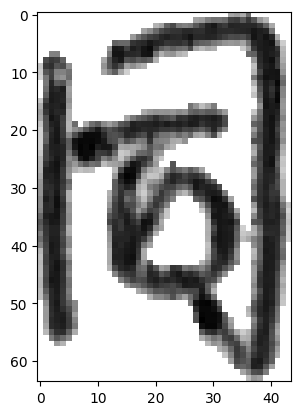

Prediction: 国. Truth: 国


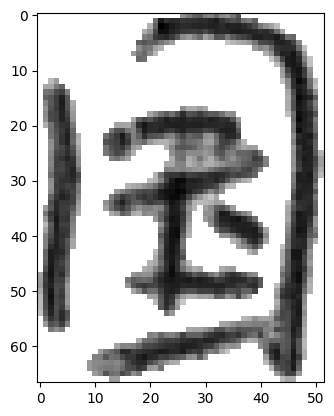

Prediction: 每. Truth: 每


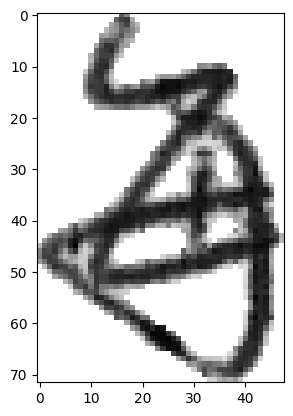

Prediction: 知. Truth: 知


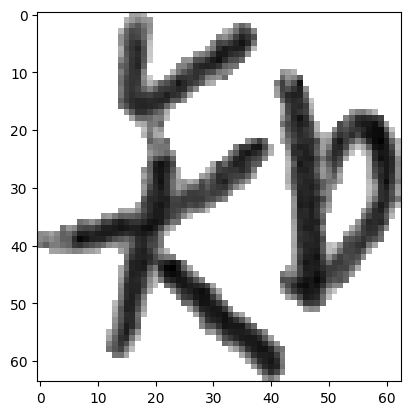

Prediction: 地. Truth: 地


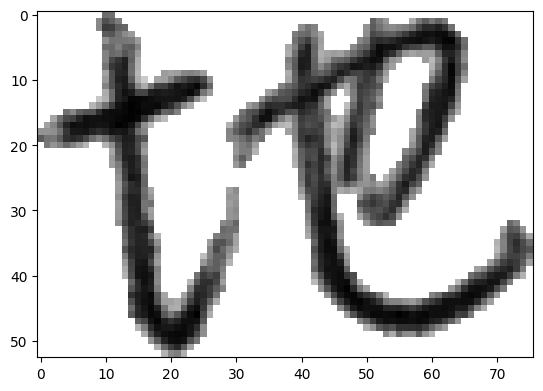

Prediction: 在. Truth: 在


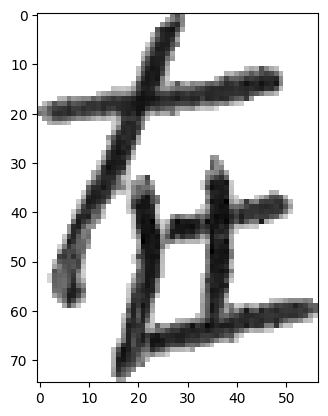

Prediction: 一. Truth: 一


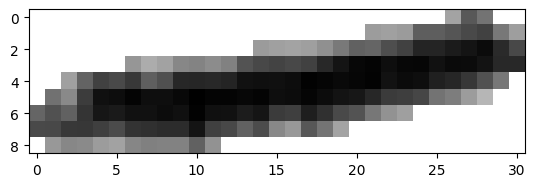

Prediction: 向. Truth: 向


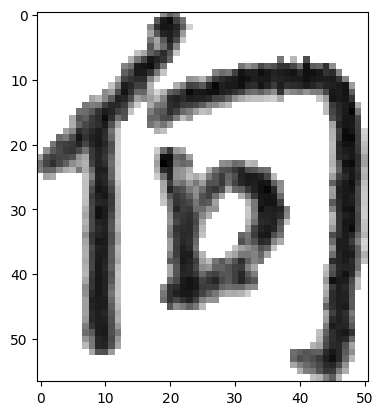

Prediction: 须. Truth: 须


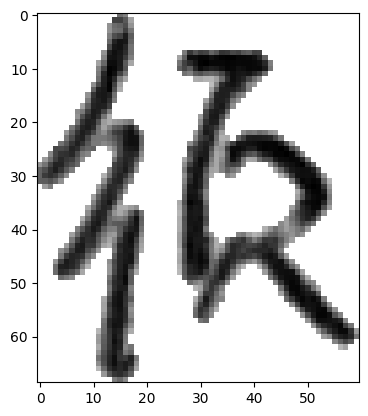

Prediction: 生. Truth: 生


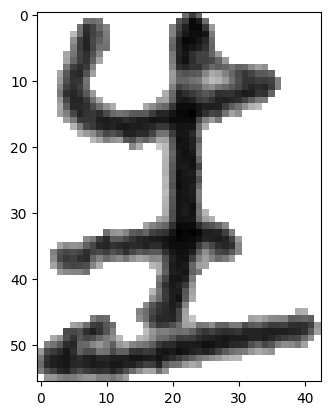

In [ ]:
testing_model(model, image_transformer, folders, interpritation_dict)

<a id="reuse-of-the-model-on-the-guilhem-dataset"></a>
## 6. Reuse of the Model on the Guilhem Dataset

/tmp/ipykernel_14104/621696383.py:18: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('./model_CRNN/best_model_120classes.pth', map_location=d


Summary Evaluation Metrics on Guilhem dataset :
accuracy: 0.0000
precision_macro: 0.0000
recall_macro: 0.0000
f1_macro: 0.0000
precision_weighted: 0.0000
recall_weighted: 0.0000
f1_weighted: 0.0000


findfont: Font family 'SimHei' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'SimHei' not found.
/tmp/ipykernel_14104/621696383.py:140: UserWarning: Glyph 25105 (\N{CJK UNIFIED IDEOGRAPH-6211}) missing from font(s) DejaVu Sans.
  plt.tight_layout()  # Adjust layout to fit all elements
findfont: Font family 'SimHei' not found.
/tmp/ipykernel_14104/621696383.py:140: UserWarning: Glyph 31532 (\N{CJK UNIFIED IDEOGRAPH-7B2C}) missing from font(s) DejaVu Sans.
  plt.tight_layout()  # Adjust layout to fit all elements
findfont: Font family 'SimHei' not found.
/tmp/ipykernel_14104/621696383.py:140: UserWarning: Glyph 34429 (\N{CJK UNIF

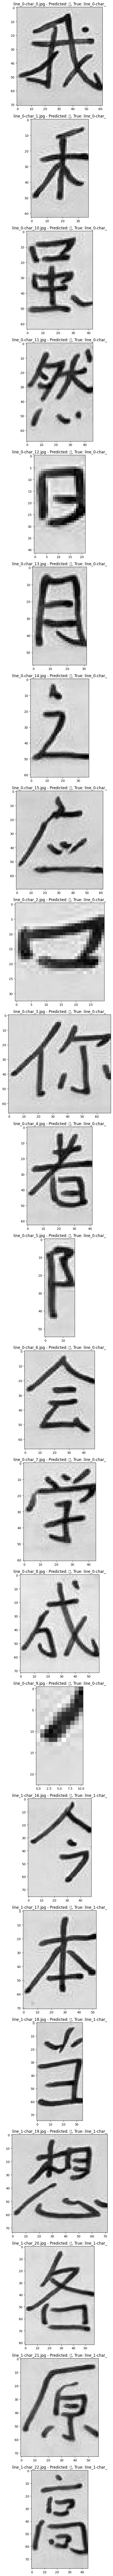

In [5]:
import os
import torch
import matplotlib.pyplot as plt
from PIL import Image
import pandas as pd
import torchvision.transforms as transforms
from sklearn.metrics import classification_report
import re

# Set font for displaying Chinese characters if needed
plt.rcParams['font.family'] = ['SimHei']  

# Load the pre-trained model and data
data = pd.read_csv("data/data_120.csv")
model = CRNN(number_class_symbols=len(data["Character"].unique()))
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.load_state_dict(torch.load('./model_CRNN/best_model_120classes.pth', map_location=device))
model.eval()  # Set the model to evaluation mode

# Load interpretation dictionary
interpretation_dict = torch.load('./model_CRNN/interpritation_dict_120classes.pth')

# Define transformations for preprocessing the images
transform = transforms.Compose([
    transforms.Resize((96, 96)),  # Resize image to 96x96 pixels
    transforms.Grayscale(num_output_channels=1),  # Convert to grayscale
    transforms.ToTensor(),  # Convert to PyTorch tensor
    transforms.RandomApply([
        transforms.RandomRotation(25),  # Random rotation
        transforms.RandomAutocontrast()  # Randomly adjust contrast
    ], p=0.6),  # Apply random transformations with 0.6 probability
    transforms.Normalize([0.5], [0.5])  # Normalize grayscale values
])

# Folder containing unlabeled images
image_folder = './Char'
predictions = []
true_labels = []
results = []

# Mapping filename to correct label if using external file (optional)
filename_to_label = dict(zip(data["Paths"], data["Character"]))  # Assuming `data_120.csv` has columns 'Filename' and 'Character'

# Process each image in the folder
for filename in os.listdir(image_folder):
    img_path = os.path.join(image_folder, filename)
    if os.path.isfile(img_path) and filename.endswith(('.png', '.jpg', '.jpeg')):
        
        # Extract the label from the filename using an external mapping if available
        true_label = filename_to_label.get(filename, None)
        
        # print(f"Processing image: {filename}")
        # print(f"True label: {true_label}")
        if true_label is None:
            # Extract label directly from filename if mapping not available
            true_label = os.path.splitext(filename)[0]
            true_label = re.sub(r'\d+$', '', true_label)  # Adjust regular expression as needed
            # print(f"Extracted label: {true_label}")
        
        # Load and transform the image
        image = Image.open(img_path).convert('L')  # Convert image to grayscale
        image_transformed = transform(image).unsqueeze(0).to(device)  # Add batch dimension and move to GPU
        
        # Make the prediction
        with torch.no_grad():  # Disable gradient calculation for efficiency
            output = model(image_transformed)  # Pass transformed image through the model
            predicted_class = torch.argmax(output, dim=1).item()  # Get the class with highest score
            predicted_char = interpretation_dict.get(predicted_class, '?')  # Use '?' for unmapped classes
            
            # Append the prediction and true label to the lists
            predictions.append(predicted_char)
            true_labels.append(true_label)
            results.append((filename, predicted_char, true_label))

# Map each unique label to a numerical index for metric calculation
unique_labels = list(set(true_labels + predictions))
label_to_index = {label: idx for idx, label in enumerate(unique_labels)}
y_true = [label_to_index[label] for label in true_labels]
y_pred = [label_to_index[label] for label in predictions]

# Calculate classification report
report = classification_report(y_true, y_pred, output_dict=True, target_names=unique_labels, zero_division=0)

# Print and save the detailed report
# print("Detailed Classification Report for Each Label:")
# for label, metrics in report.items():
#     if label.isdigit():  # Check if the key is a class label
#         label_name = interpretation_dict[int(label)]
#         print(f"Label '{label_name}' (Class {label}):")
#         print(f"  Precision: {metrics['precision']:.4f}")
#         print(f"  Recall:    {metrics['recall']:.4f}")
#         print(f"  F1 Score:  {metrics['f1-score']:.4f}")
#         print(f"  Support:   {metrics['support']}\n")

# Extract overall metrics from the report
metrics = {
    'accuracy': report['accuracy'],
    'precision_macro': report['macro avg']['precision'],
    'recall_macro': report['macro avg']['recall'],
    'f1_macro': report['macro avg']['f1-score'],
    'precision_weighted': report['weighted avg']['precision'],
    'recall_weighted': report['weighted avg']['recall'],
    'f1_weighted': report['weighted avg']['f1-score']
}

# Print summary metrics
print("\nSummary Evaluation Metrics on Guilhem dataset :")
for metric, value in metrics.items():
    print(f"{metric}: {value:.4f}")

# Save detailed metrics to a text file
with open("model/best_model_guilhem_dataset_eval.txt", 'w') as f:
    # Write summary metrics
    f.write("Summary Evaluation Metrics on Guilhem dataset:\n")
    for metric, value in metrics.items():
        f.write(f"{metric}: {value:.4f}\n")
    
    # f.write("\nDetailed Classification Report for Each Label:\n")
    # for label, metrics in report.items():
    #     if label.isdigit():
    #         label_name = interpretation_dict[int(label)]
    #         f.write(f"Label '{label_name}' (Class {label}):\n")
    #         f.write(f"  Precision: {metrics['precision']:.4f}\n")
    #         f.write(f"  Recall:    {metrics['recall']:.4f}\n")
    #         f.write(f"  F1 Score:  {metrics['f1-score']:.4f}\n")
    #         f.write(f"  Support:   {metrics['support']}\n\n")
    

# Now we can display the images with the correct labels
fig, axes = plt.subplots(nrows=len(results), ncols=1, figsize=(10, 5 * len(results)))

# Loop through results to display each image with its predicted and true label
for ax, (filename, predicted_char, true_label) in zip(axes, results):
    img_path = os.path.join(image_folder, filename)
    img = Image.open(img_path).convert('L')  # Reload the original image in grayscale
    ax.imshow(img, cmap='gray')  # Display the grayscale image
    ax.set_title(f"{filename} - Predicted: {predicted_char}, True: {true_label}")  # Set title with filename and labels

plt.tight_layout()  # Adjust layout to fit all elements
plt.show()  # Display the figure

**Interprétation des résultats pour CRNN**

**Performances sur data_120**: Les résultats sont bien plus élevés ici, avec des performances très équilibrées entre précision et rappel (aux alentours de 85-86 %). Cela signifie que le CRNN parvient à reconnaître efficacement les caractères de manière régulière dans ce corpus de test, probablement parce qu’il a été entraîné sur un dataset similaire dans sa structure et complexité. Le CRNN montre ainsi sa capacité à bien modéliser des séquences même sans utiliser un contexte linguistique explicite.

**Performances sur dataset Guilhem**: Les résultats sur le dataset Guilhem montrent des scores plus faibles que ceux d'OpenVINO, bien que CRNN ait un rappel légèrement plus élevé. Le CRNN est mieux adapté pour capturer des séquences complexes, mais il semble moins efficace pour reconnaître des caractères individuels dans ce dataset, probablement en raison des variabilités de style manuscrit. La couverture relativement équilibrée entre précision et rappel suggère que le modèle n’a pas de biais notable pour certains caractères comme c’est le cas avec OpenVINO, mais qu'il n’atteint pas la précision suffisante pour chaque